In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torchvision.models as models
import copy

In [2]:
# Configure the device gpu is required for faster 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
IMG_SIZE = 512
data_loader = transforms.Compose([transforms.Resize((IMG_SIZE, IMG_SIZE)), transforms.ToTensor()])
def load_img(filename):
    image = Image.open(filename)
    image = data_loader(image).unsqueeze(0)
    return image.to(device, torch.float)
style_img = load_img("./data/images/style.jpg")
content_img = load_img("./data/images/content.jpg")

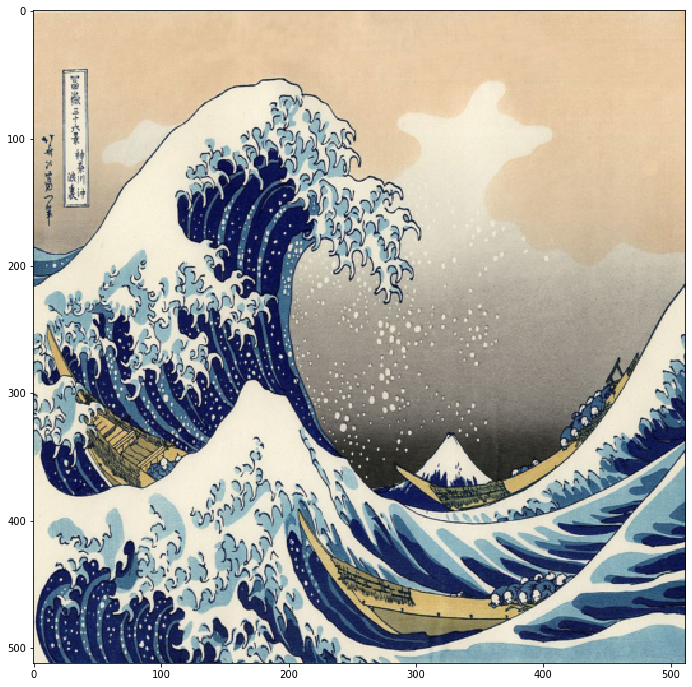

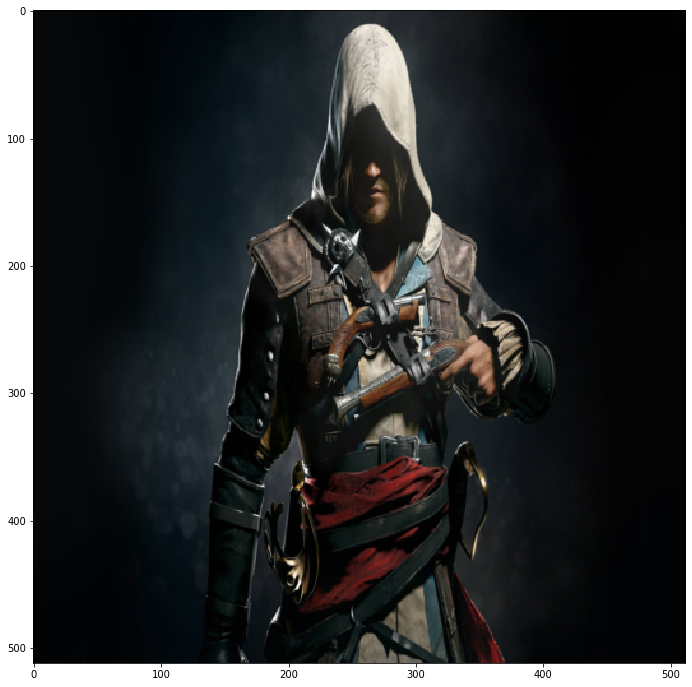

In [4]:
unloader = transforms.ToPILImage()
plt.ion()

def imshow(tensor):
    image = tensor.cpu().clone()
    image = image.squeeze(0)
    image = unloader(image)
    plt.imshow(image)
    plt.pause(0.001)
    
plt.figure(figsize = (15,12))  
imshow(style_img)

plt.figure(figsize = (15,12))
imshow(content_img)

In [5]:
# CONTENT LOSS FUNCTION
class ContentLoss(nn.Module):
    def __init__(self, target):
        super(ContentLoss, self).__init__()
        self.target = target.detach()
    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

In [6]:
def gram_matrix(tensor):
    a, b, c, d = tensor.size()
    #example (1, 256, 56, 56)
    tensor = tensor.view(a*b, c*d)
    #out (256, 3136)
    G = torch.mm(tensor, tensor.t())
    return G.div(b*c*d)

In [7]:
class StyleLoss(nn.Module):
    def __init__(self, target_features):
        super(StyleLoss, self).__init__()
        self.target_gram = gram_matrix(target_features).detach()
        
    def forward(self, input):
        in_gram = gram_matrix(input)
        self.loss = F.mse_loss(in_gram, self.target_gram)
        return input

In [8]:
#loading VGG19
vgg_19 = models.vgg19(pretrained=True).features.to(device).eval()

In [9]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)
        
    def forward(self, in_image):
        return (in_image - self.mean)/self.std

In [10]:
# LAYERS TO USE
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

In [11]:
def get_model_style_losses(cnn, mean, std, style_img, content_img, content_layers = content_layers_default,
                           style_layers = style_layers_default):
    cnn = copy.deepcopy(cnn)
    normal = Normalization(mean, std).to(device)
    content_losses = []
    style_losses = []
    model = nn.Sequential(normal)
    i = 0
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i+=1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))
        model.add_module(name, layer)
        
        if name in content_layers:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)
        if name in style_layers:
            target_features = model(style_img).detach()
            style_loss = StyleLoss(target_features)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break
    model = model[:(i + 1)]
    return model, style_losses, content_losses